In [1]:
import numpy as np
import scipy.spatial.distance as sd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
import os.path
import pdb
cuda = torch.device('cuda') 
import scipy as sp
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from random import sample
import random
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn import preprocessing
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from scipy import stats
from sklearn import svm

In [2]:
def train_epoch(model, X_train, y_train, opt, criterion, sim, batch_size=200):
    model.train()
    sim = sim
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch.float())
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        #print(loss)
        reg = torch.tensor(0., requires_grad=True)
        for name, param in net.fc1.named_parameters():
            if 'weight' in name:
#                 reg = torch.norm(reg + param @ sim.float() @ param.T, 2)
                M = .5 * ((torch.eye(feature_dim) - sim).T @ (torch.eye(feature_dim) - sim)) + .5 * torch.eye(feature_dim)
                reg = torch.norm(reg + param @ M.float() @ param.T, 2)
                loss += reg
#         for param in model.parameters():
#             loss += .1 * torch.sum(torch.abs(param))
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [3]:
def train_epoch_noreg(model, X_train, y_train, opt, criterion, sim, batch_size=200):
    model.train()
    sim = sim
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch.float())
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        #print(loss)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50,5)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

# Classify layer

In [5]:
Efeature = pd.read_csv('../data/efeature_filtered.csv',index_col=0)
geneExp = pd.read_csv('../data/expMat_filtered.csv',index_col=0)
label = pd.read_csv('../data/label_visual.csv')
feature_new = pd.read_csv("../data/deepmanreg_latent.csv",index_col=0)
ma_latent = pd.read_csv("../data/visual/ma_latent.csv").to_numpy()
cca_latent = pd.read_csv("../data/visual/cca_latent.csv").to_numpy()
matcher_latent = pd.read_csv("../data/visual/matcher_latent.csv").to_numpy()

#x1_np = preprocessing.scale(np.log(geneExp+1).to_numpy(),axis=1)
#x2_np = preprocessing.scale(Efeature.T.to_numpy(),axis=1)

x1_np = np.log(geneExp+1).to_numpy()
x2_np = preprocessing.scale(Efeature.T.to_numpy(),axis=1)

data = np.concatenate((x1_np,x2_np), axis=0).T
print(data.shape)

distance_matrix = sp.spatial.distance_matrix(feature_new, feature_new)
#sim_mat = 1/(1+distance_matrix)
sim_mat = 1/np.exp(distance_matrix)
sim_mat[sim_mat > np.percentile(sim_mat,50)] = 1
sim_mat[sim_mat != 1] = 0
sim = torch.from_numpy(sim_mat)
sim = sim.fill_diagonal_(0).float()

distance_matrix2 = sp.spatial.distance_matrix(ma_latent,ma_latent)
sim_mat2 = 1/(1+distance_matrix2)
sim_mat2[sim_mat2 > np.percentile(sim_mat2,50)] = 1
sim_mat2[sim_mat2 != 1] = 0
sim2 = torch.from_numpy(sim_mat2)
sim2 = sim2.fill_diagonal_(0).float()

distance_matrix3 = sp.spatial.distance_matrix(cca_latent,cca_latent)
sim_mat3 = 1/(1+distance_matrix3)
sim_mat3[sim_mat3 > np.percentile(sim_mat3,50)] = 1
sim_mat3[sim_mat3 != 1] = 0
sim3 = torch.from_numpy(sim_mat3)
sim3 = sim3.fill_diagonal_(0).float()

distance_matrix4 = sp.spatial.distance_matrix(matcher_latent,matcher_latent)
sim_mat4 = 1/(1+distance_matrix4)
sim_mat4[sim_mat4 > np.percentile(sim_mat4,50)] = 1
sim_mat4[sim_mat4 != 1] = 0
sim4 = torch.from_numpy(sim_mat4)
sim4 = sim4.fill_diagonal_(0).float()

labels = label.iloc[:,3].to_numpy()

(3654, 1041)


# train test split

In [11]:
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
acc_reg = []
acc_noreg = []
acc_ma = []
acc_cca = []
acc_matcher = []

pred_reg = []
pred_noreg = []
pred_ma = []
pred_cca = []
pred_matcher = []

#weights = [448,719,43,214,1456,684]
#weights = {3: 1176, 1: 1097, 4: 734, 2: 385, 0: 262}
#weights = [1 - (x / sum(weights)) for x in weights]
#weights = torch.tensor(weights, dtype=torch.float32)
X = data
y = pd.factorize(labels,sort=True)[0]
#X_train_vali, X_test, y_train_vali, y_test = train_test_split(X,y,test_size=0.2, 
#                                                        random_state=0, stratify = y)
#X_test, y_test = SMOTE.fit_resample(X_test, y_test)
#print("After oversampling test: ",Counter(y_test))
#X, y = SMOTE.fit_resample(X, y)
for i in range(100):
    #X_train, X_vali, y_train, y_vali = train_test_split(X_train_vali,y_train_vali,test_size=0.2, 
    #                                                    random_state=i, stratify = y_train_vali)
    X_train, X_vali, y_train, y_vali = train_test_split(X,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    
    #print("Before oversampling: ",Counter(y_train))

    # fit and apply the transform
    X_train, y_train = SMOTE(random_state=i).fit_resample(X_train, y_train)
    #X_vali, y_vali = SMOTE.fit_resample(X_vali, y_vali)
    # summarize class distribution
    if i == 0:
        print("After oversampling train: ",Counter(y_train))
        print("Without oversampling Validation: ",Counter(y_vali))
    
    torch.manual_seed(i)
    
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    
    # no regulized network
    feature_dim = 1041
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train, y_train, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (unregularized):",correct_pred)
    acc_noreg.append(np.mean(correct_pred)) 
    pred_noreg.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    # regulized network   
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (regularized):",correct_pred)
    acc_reg.append(np.mean(correct_pred))
    pred_reg.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    # manifold alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim2)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (manifold alignment):",correct_pred)
    acc_ma.append(np.mean(correct_pred))
    pred_ma.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    #cca alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (cca):",correct_pred)
    acc_cca.append(np.mean(correct_pred))
    pred_cca.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    #matcher alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (matcher):",correct_pred)
    acc_matcher.append(np.mean(correct_pred))
    pred_matcher.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

After oversampling train:  Counter({3: 941, 2: 941, 4: 941, 1: 941, 0: 941})
Without oversampling Validation:  Counter({3: 235, 1: 220, 4: 147, 2: 77, 0: 52})
Round 0 Test Accuracy (unregularized): 0.07113543091655267
Round 0 Test Accuracy (regularized): 0.49658002735978113
Round 0 Test Accuracy (manifold alignment): 0.426812585499316
Round 0 Test Accuracy (cca): 0.3967168262653899
Round 0 Test Accuracy (matcher): 0.4172366621067031
Round 1 Test Accuracy (unregularized): 0.4528043775649795
Round 1 Test Accuracy (regularized): 0.4883720930232558
Round 1 Test Accuracy (manifold alignment): 0.42544459644322846
Round 1 Test Accuracy (cca): 0.39398084815321477
Round 1 Test Accuracy (matcher): 0.4719562243502052
Round 2 Test Accuracy (unregularized): 0.07113543091655267
Round 2 Test Accuracy (regularized): 0.5471956224350205
Round 2 Test Accuracy (manifold alignment): 0.44049247606019154
Round 2 Test Accuracy (cca): 0.4637482900136799
Round 2 Test Accuracy (matcher): 0.46238030095759236
Roun

Round 28 Test Accuracy (cca): 0.4103967168262654
Round 28 Test Accuracy (matcher): 0.43502051983584133
Round 29 Test Accuracy (unregularized): 0.31874145006839943
Round 29 Test Accuracy (regularized): 0.5622435020519836
Round 29 Test Accuracy (manifold alignment): 0.47332421340629277
Round 29 Test Accuracy (cca): 0.44049247606019154
Round 29 Test Accuracy (matcher): 0.48700410396716826
Round 30 Test Accuracy (unregularized): 0.27906976744186046
Round 30 Test Accuracy (regularized): 0.5170998632010944
Round 30 Test Accuracy (manifold alignment): 0.44459644322845415
Round 30 Test Accuracy (cca): 0.4487004103967168
Round 30 Test Accuracy (matcher): 0.4801641586867305
Round 31 Test Accuracy (unregularized): 0.3679890560875513
Round 31 Test Accuracy (regularized): 0.49794801641586867
Round 31 Test Accuracy (manifold alignment): 0.43091655266757867
Round 31 Test Accuracy (cca): 0.4829001367989056
Round 31 Test Accuracy (matcher): 0.478796169630643
Round 32 Test Accuracy (unregularized): 0.33

Round 57 Test Accuracy (cca): 0.478796169630643
Round 57 Test Accuracy (matcher): 0.45964432284541723
Round 58 Test Accuracy (unregularized): 0.07113543091655267
Round 58 Test Accuracy (regularized): 0.533515731874145
Round 58 Test Accuracy (manifold alignment): 0.454172366621067
Round 58 Test Accuracy (cca): 0.45964432284541723
Round 58 Test Accuracy (matcher): 0.3652530779753762
Round 59 Test Accuracy (unregularized): 0.10533515731874145
Round 59 Test Accuracy (regularized): 0.5047879616963065
Round 59 Test Accuracy (manifold alignment): 0.45006839945280436
Round 59 Test Accuracy (cca): 0.4692202462380301
Round 59 Test Accuracy (matcher): 0.4363885088919289
Round 60 Test Accuracy (unregularized): 0.4172366621067031
Round 60 Test Accuracy (regularized): 0.4746922024623803
Round 60 Test Accuracy (manifold alignment): 0.4172366621067031
Round 60 Test Accuracy (cca): 0.45143638850889195
Round 60 Test Accuracy (matcher): 0.4062927496580027
Round 61 Test Accuracy (unregularized): 0.1135430

Round 86 Test Accuracy (cca): 0.4131326949384405
Round 86 Test Accuracy (matcher): 0.42954856361149113
Round 87 Test Accuracy (unregularized): 0.28454172366621067
Round 87 Test Accuracy (regularized): 0.521203830369357
Round 87 Test Accuracy (manifold alignment): 0.33652530779753764
Round 87 Test Accuracy (cca): 0.4692202462380301
Round 87 Test Accuracy (matcher): 0.4582763337893297
Round 88 Test Accuracy (unregularized): 0.3392612859097127
Round 88 Test Accuracy (regularized): 0.5157318741450069
Round 88 Test Accuracy (manifold alignment): 0.41450068399452805
Round 88 Test Accuracy (cca): 0.46101231190150477
Round 88 Test Accuracy (matcher): 0.4801641586867305
Round 89 Test Accuracy (unregularized): 0.08344733242134063
Round 89 Test Accuracy (regularized): 0.5129958960328317
Round 89 Test Accuracy (manifold alignment): 0.45554035567715456
Round 89 Test Accuracy (cca): 0.46101231190150477
Round 89 Test Accuracy (matcher): 0.4856361149110807
Round 90 Test Accuracy (unregularized): 0.519

In [12]:
pred_reg = np.array(pred_reg)
pred_noreg = np.array(pred_noreg)
pred_ma= np.array(pred_ma)
pred_cca = np.array(pred_cca)
pred_matcher = np.array(pred_matcher)

In [13]:
np.savetxt("../data/visual/pred_reg.csv", pred_reg, delimiter=",")
np.savetxt("../data/visual/pred_noreg.csv", pred_noreg, delimiter=",")
np.savetxt("../data/visual/pred_ma.csv", pred_ma, delimiter=",")
np.savetxt("../data/visual/pred_cca.csv", pred_cca, delimiter=",")
np.savetxt("../data/visual/pred_matcher.csv", pred_matcher, delimiter=",")
np.savetxt("../data/visual/y_vali.csv", y_vali, delimiter=",")

In [19]:
scipy.stats.ks_2samp(acc_reg,acc_matcher)

KstestResult(statistic=0.81, pvalue=3.93815390175582e-33)

In [28]:
np.percentile(acc_matcher,[2.5,50,97.5])

array([0.38153215, 0.45827633, 0.5123461 ])

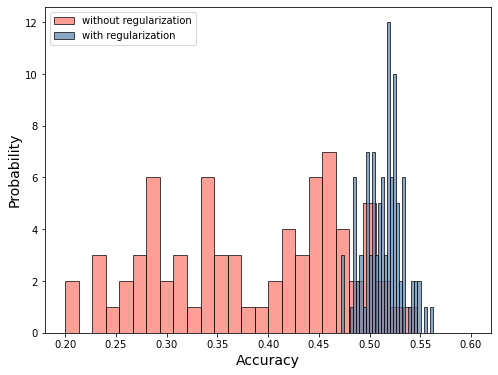

In [30]:
plt.figure(figsize=(8,6))
reg = plt.hist(acc_noreg, bins=30, range=[0.2, 0.6],color = "#FC766AFF",alpha=0.7,density=False, histtype='bar', ec='black')
noreg = plt.hist(acc_reg, bins=30, alpha=0.7,color = "#5B84B1FF",density=False, histtype='bar', ec='black')
plt.xlabel("Accuracy", size=14)
plt.ylabel("Probability", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'with regularization'])
plt.savefig("../figure/hist_validation.pdf")

F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-leve

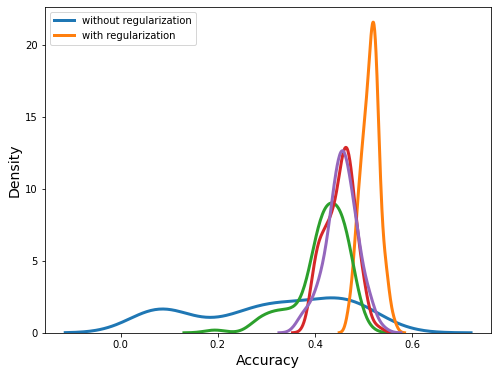

In [37]:
plt.figure(figsize=(8,6))
sns.distplot(acc_noreg, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_reg, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_ma, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_cca, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_matcher, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
plt.xlabel("Accuracy", size=14)
plt.ylabel("Density", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'with regularization'])
plt.savefig("../figure/hist_validation.pdf")

# Final Model

In [38]:
#network for all data
X = data
y = pd.factorize(labels,sort=True)[0]
X, y = SMOTE(random_state = 0).fit_resample(X, y)
print("After oversampling whole: ",Counter(y))

X = torch.tensor(X)
y = torch.tensor(y)
    
torch.manual_seed(0)
np.random.seed(0)
net = Net()
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
e_losses = []
num_epochs = 20
for e in range(num_epochs):
    e_losses += train_epoch(net, X, y, opt, criterion, sim)

with torch.no_grad():
    x_tensor_test = X.float()#.to(device)
    net.eval()
    yhat = net(x_tensor_test)
y_pred_softmax = torch.log_softmax(yhat, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
correct_pred = np.mean([float(y_pred_tags[i] == y[i]) for i in range(len(y))])
print("Train Accuracy (regularized):",correct_pred)

After oversampling whole:  Counter({3: 1176, 1: 1176, 4: 1176, 2: 1176, 0: 1176})
Train Accuracy (regularized): 0.6299319727891156


# ROC curve

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
fpr = dict()
tpr = dict()
roc_auc = dict()
real = label_binarize(y, classes=range(5))
pred = y_pred_softmax.detach().numpy()
#pred = net(X_train.float()).detach().numpy()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(real[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(real.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-leve

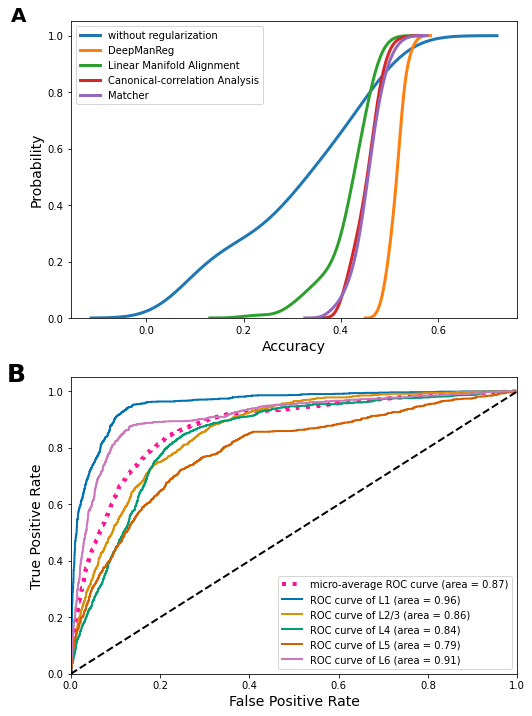

In [58]:
# Plot all ROC curves
layer=["L1","L2/3","L4","L5","L6"]
plt.figure(figsize=(8,12))
ax=plt.subplot(211)
sns.distplot(acc_noreg, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_reg, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_ma, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_cca, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_matcher, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
plt.xlabel("Accuracy", size=14)
plt.ylabel("Probability", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'DeepManReg',"Linear Manifold Alignment","Canonical-correlation Analysis","Matcher"])
#plt.savefig("../figure/hist_validation.eps")
ax.text(-0.1, 1.05, "A", transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
lw = 2
ax=plt.subplot(212)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = sns.color_palette("colorblind")
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of '+layer[i]+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.title('')
plt.legend(loc="lower right")
ax.text(-0.1, 1.05, "B", transform=ax.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
plt.savefig("../figure/Roc_curve.eps")
plt.savefig("../figure/Roc_curve.pdf")
plt.show()

# Classify t-type

In [50]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50,6)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
acc_reg_t = []
acc_noreg_t = []
acc_ma_t = []
acc_cca_t = []
acc_matcher_t = []

pred_reg_t = []
pred_noreg_t = []
pred_ma_t = []
pred_cca_t = []
pred_matcher_t = []

#weights = [448,719,43,214,1456,684]
#weights = {3: 1176, 1: 1097, 4: 734, 2: 385, 0: 262}
#weights = [1 - (x / sum(weights)) for x in weights]
#weights = torch.tensor(weights, dtype=torch.float32)
X = data
labels = label.iloc[:,1].to_numpy()
y = pd.factorize(labels,sort=True)[0]
#X_train_vali, X_test, y_train_vali, y_test = train_test_split(X,y,test_size=0.2, 
#                                                        random_state=0, stratify = y)
#X_test, y_test = SMOTE.fit_resample(X_test, y_test)
#print("After oversampling test: ",Counter(y_test))
#X, y = SMOTE.fit_resample(X, y)
for i in range(100):
    #X_train, X_vali, y_train, y_vali = train_test_split(X_train_vali,y_train_vali,test_size=0.2, 
    #                                                    random_state=i, stratify = y_train_vali)
    X_train, X_vali, y_train, y_vali = train_test_split(X,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    
    #print("Before oversampling: ",Counter(y_train))

    # fit and apply the transform
    X_train, y_train = SMOTE(random_state=i).fit_resample(X_train, y_train)
    #X_vali, y_vali = SMOTE.fit_resample(X_vali, y_vali)
    # summarize class distribution
    if i == 0:
        print("After oversampling train: ",Counter(y_train))
        print("Without oversampling Validation: ",Counter(y_vali))
    
    torch.manual_seed(i)
    
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    
    # no regulized network
    feature_dim = 1041
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train, y_train, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (unregularized):",correct_pred)
    acc_noreg_t.append(np.mean(correct_pred)) 
    pred_noreg_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    # regulized network   
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (regularized):",correct_pred)
    acc_reg_t.append(np.mean(correct_pred))
    pred_reg_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    # manifold alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim2)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (manifold alignment):",correct_pred)
    acc_ma_t.append(np.mean(correct_pred))
    pred_ma_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    #cca alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (cca):",correct_pred)
    acc_cca_t.append(np.mean(correct_pred))
    pred_cca_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    #matcher alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (matcher):",correct_pred)
    acc_matcher_t.append(np.mean(correct_pred))
    pred_matcher_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

After oversampling train:  Counter({4: 1237, 1: 1237, 3: 1237, 5: 1237, 0: 1237, 2: 1237})
Without oversampling Validation:  Counter({4: 309, 1: 144, 5: 137, 0: 90, 3: 43, 2: 8})
Round 0 Test Accuracy (unregularized): 0.7674418604651163
Round 0 Test Accuracy (regularized): 0.8974008207934336
Round 0 Test Accuracy (manifold alignment): 0.31874145006839943
Round 0 Test Accuracy (cca): 0.667578659370725
Round 0 Test Accuracy (matcher): 0.6593707250341997
Round 1 Test Accuracy (unregularized): 0.7168262653898769
Round 1 Test Accuracy (regularized): 0.8946648426812586
Round 1 Test Accuracy (manifold alignment): 0.2476060191518468
Round 1 Test Accuracy (cca): 0.801641586867305
Round 1 Test Accuracy (matcher): 0.387140902872777
Round 2 Test Accuracy (unregularized): 0.39398084815321477
Round 2 Test Accuracy (regularized): 0.9069767441860465
Round 2 Test Accuracy (manifold alignment): 0.2640218878248974
Round 2 Test Accuracy (cca): 0.719562243502052
Round 2 Test Accuracy (matcher): 0.588235294

Round 28 Test Accuracy (cca): 0.560875512995896
Round 28 Test Accuracy (matcher): 0.29001367989056087
Round 29 Test Accuracy (unregularized): 0.8864569083447332
Round 29 Test Accuracy (regularized): 0.9124487004103967
Round 29 Test Accuracy (manifold alignment): 0.38303693570451436
Round 29 Test Accuracy (cca): 0.5554035567715458
Round 29 Test Accuracy (matcher): 0.7113543091655267
Round 30 Test Accuracy (unregularized): 0.7879616963064295
Round 30 Test Accuracy (regularized): 0.920656634746922
Round 30 Test Accuracy (manifold alignment): 0.22571819425444598
Round 30 Test Accuracy (cca): 0.7414500683994528
Round 30 Test Accuracy (matcher): 0.761969904240766
Round 31 Test Accuracy (unregularized): 0.8030095759233926
Round 31 Test Accuracy (regularized): 0.9233926128590971
Round 31 Test Accuracy (manifold alignment): 0.48700410396716826
Round 31 Test Accuracy (cca): 0.8221614227086184
Round 31 Test Accuracy (matcher): 0.801641586867305
Round 32 Test Accuracy (unregularized): 0.7633378932

Round 57 Test Accuracy (cca): 0.5294117647058824
Round 57 Test Accuracy (matcher): 0.6894664842681258
Round 58 Test Accuracy (unregularized): 0.8235294117647058
Round 58 Test Accuracy (regularized): 0.9370725034199726
Round 58 Test Accuracy (manifold alignment): 0.3447332421340629
Round 58 Test Accuracy (cca): 0.8207934336525308
Round 58 Test Accuracy (matcher): 0.3543091655266758
Round 59 Test Accuracy (unregularized): 0.320109439124487
Round 59 Test Accuracy (regularized): 0.8700410396716827
Round 59 Test Accuracy (manifold alignment): 0.09302325581395349
Round 59 Test Accuracy (cca): 0.4487004103967168
Round 59 Test Accuracy (matcher): 0.1518467852257182
Round 60 Test Accuracy (unregularized): 0.9165526675786594
Round 60 Test Accuracy (regularized): 0.896032831737346
Round 60 Test Accuracy (manifold alignment): 0.24623803009575923
Round 60 Test Accuracy (cca): 0.5485636114911081
Round 60 Test Accuracy (matcher): 0.6839945280437757
Round 61 Test Accuracy (unregularized): 0.4158686730

Round 86 Test Accuracy (matcher): 0.7113543091655267
Round 87 Test Accuracy (unregularized): 0.9548563611491108
Round 87 Test Accuracy (regularized): 0.9151846785225718
Round 87 Test Accuracy (manifold alignment): 0.12722298221614228
Round 87 Test Accuracy (cca): 0.6894664842681258
Round 87 Test Accuracy (matcher): 0.426812585499316
Round 88 Test Accuracy (unregularized): 0.31600547195622436
Round 88 Test Accuracy (regularized): 0.9124487004103967
Round 88 Test Accuracy (manifold alignment): 0.060191518467852256
Round 88 Test Accuracy (cca): 0.5636114911080712
Round 88 Test Accuracy (matcher): 0.7455540355677155
Round 89 Test Accuracy (unregularized): 0.8290013679890561
Round 89 Test Accuracy (regularized): 0.9343365253077975
Round 89 Test Accuracy (manifold alignment): 0.19562243502051985
Round 89 Test Accuracy (cca): 0.4897400820793434
Round 89 Test Accuracy (matcher): 0.6142270861833106
Round 90 Test Accuracy (unregularized): 0.8549931600547196
Round 90 Test Accuracy (regularized): 

In [56]:
np.percentile(acc_noreg_t,[2.5,50,97.5])

array([0.20167579, 0.77154583, 0.92876197])

In [ ]:
np.mean(acc_reg_t)